<a href="https://colab.research.google.com/github/sidharth178/Youtube-Adview-Prediction/blob/master/youtube_adview_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**===========YouTube AdView Prediction============**</center>

# **1. Introduction**
### **Objective:** 
To build a machine learning model which will predict youtube adview count based on other youtube metrics.
### **Data Description:**
- train.csv - the training set
- test.csv - the test set
- The file train.csv contains metrics and other details of about 15000 youtube videos. The metrics include number of views, likes, dislikes, comments and apart from that published date, duration and category are also included. The train.csv file also contains the metric number of adviews which is our target variable for prediction.

### **Table of Content:**
1. Introduction
2. Install & Import Libraries
3. Load Datasets
4. Exploratory Data Analysis
5. Feature Engineering
6. Model Development
7. Find Prediction





# **2. Install & Import Libraries**

- Run the below cell, if you've not install these libraries before.

In [107]:
# # use to visualize missing value
# !pip install missingno

# # use for hyper parameter tuning
# !pip install optuna


In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

from scipy import stats
from scipy.stats import norm, skew # for some statistics
import warnings # to ignore warning
from sklearn.preprocessing import RobustScaler, PowerTransformer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import optuna
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
import joblib

import warnings
warnings.filterwarnings('ignore')
print("Library Imported!!")

Library Imported!!


# **3. Load Datasets**

In [55]:
# load train and test dataset
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# **4. Exploratory Data Analysis**
### 4.1. Train Data Exploration

For both train and test dataset, We'll explore following things

- First 5 rows
- Data shape
- Data information
- Data types
- Null value

### 4.1.1. First 5 records

In [56]:
train_df.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


### 4.1.2. Data Shape - Train Data

In [57]:
train_df.shape

(14999, 9)

### 4.1.3. Data Information - Train Data

In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   vidid      14999 non-null  object
 1   adview     14999 non-null  int64 
 2   views      14999 non-null  object
 3   likes      14999 non-null  object
 4   dislikes   14999 non-null  object
 5   comment    14999 non-null  object
 6   published  14999 non-null  object
 7   duration   14999 non-null  object
 8   category   14999 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.0+ MB


### 4.1.4. Statistical analysis - Train Data

In [59]:
train_df.describe(include='all')

,vidid,adview,views,likes,dislikes,comment,published,duration,category
count,14999,1.499900e+04,14999,14999,14999,14999,14999,14999,14999
unique,14999,NaN,14588,4789,1546,2007,2386,3146,8
top,VID_12352,NaN,238,1,0,0,2016-08-26,PT31S,D
freq,1,NaN,4,174,1091,1290,42,147,7558
mean,NaN,2.107791e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,5.237711e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,6.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.1.5. Data Type - Train Data

In [60]:
train_dtype = train_df.dtypes
train_dtype.value_counts()

object    8
int64     1
dtype: int64

### 4.1.6. Null Value - Train Data

In [61]:
train_df.isnull().sum().sort_values(ascending = False).head(10)

category     0
duration     0
published    0
comment      0
dislikes     0
likes        0
views        0
adview       0
vidid        0
dtype: int64

### 4.1.7. Visualize missing value using **Misingno** - Train Data

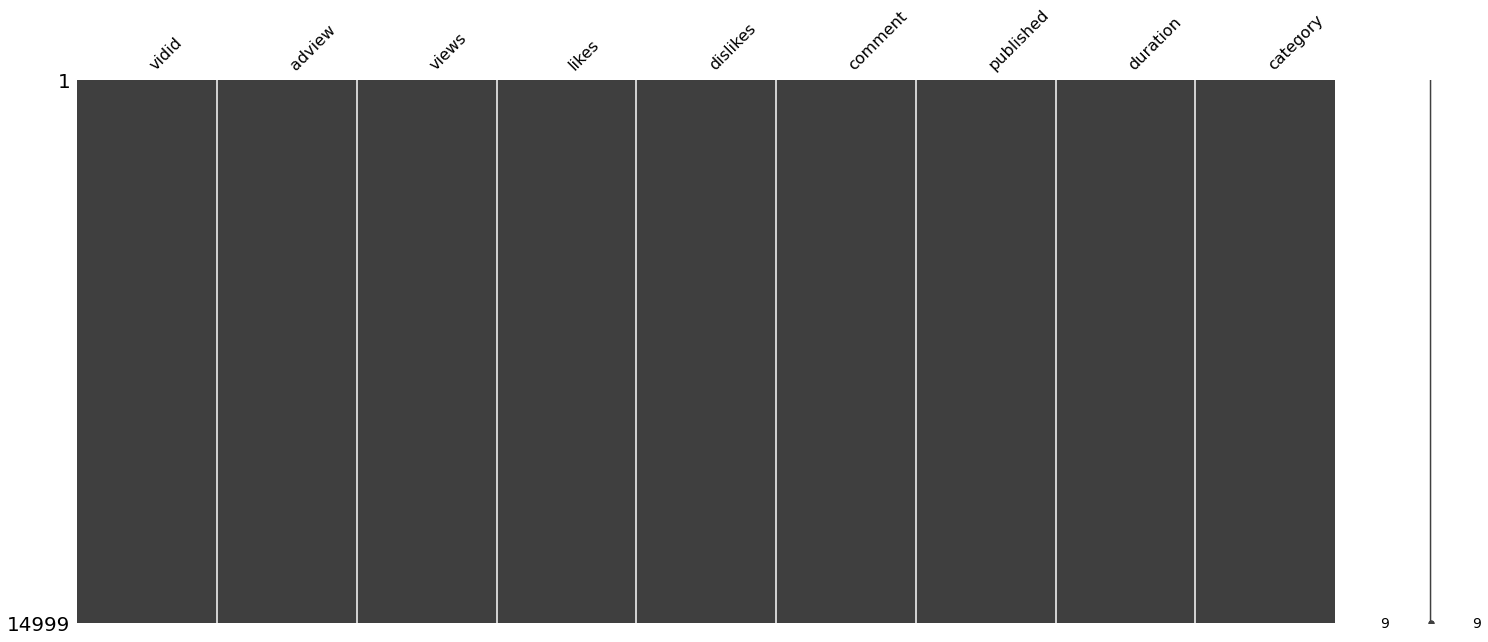

In [62]:
msno.matrix(train_df)

### 4.2. Test Data Exploration

### 4.2.1. First 5 rows - Test Data

In [63]:
test_df.head()

,vidid,views,likes,dislikes,comment,published,duration,category
0,VID_1054,440238,6153,218,1377,2017-02-18,PT7M29S,B
1,VID_18629,1040132,8171,340,1047,2016-06-28,PT6M29S,F
2,VID_13967,28534,31,11,1,2014-03-10,PT37M54S,D
3,VID_19442,1316715,2284,250,274,2010-06-05,PT9M55S,G
4,VID_770,1893173,2519,225,116,2016-09-03,PT3M8S,B


### 4.2.2. Data Shape - Test Data

In [64]:
test_df.shape

(8764, 8)

### 4.2.3. Data Type - Test Data

In [65]:
test_dtype = test_df.dtypes
test_dtype.value_counts()

object    8
dtype: int64

### 4.2.4. Data Information - Test Data

In [66]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8764 entries, 0 to 8763
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   vidid      8764 non-null   object
 1   views      8764 non-null   object
 2   likes      8764 non-null   object
 3   dislikes   8764 non-null   object
 4   comment    8764 non-null   object
 5   published  8764 non-null   object
 6   duration   8764 non-null   object
 7   category   8764 non-null   object
dtypes: object(8)
memory usage: 547.9+ KB


### 4.2.5. Statistical analysis - Test Data

In [67]:
test_df.describe(include='all')

,vidid,views,likes,dislikes,comment,published,duration,category
count,8764,8764,8764,8764,8764,8764,8764,8764
unique,8764,8605,3434,1215,1556,2109,2330,8
top,VID_14440,36679,2,0,0,2016-08-26,PT31S,D
freq,1,3,89,662,727,32,120,4419


### 4.2.6. Null Data - Test Data

In [68]:
test_df.isnull().sum().sort_values(ascending = False).head(10)

category     0
duration     0
published    0
comment      0
dislikes     0
likes        0
views        0
vidid        0
dtype: int64

### 4.2.7. Visualize missing value using **Misingno** - Test Data

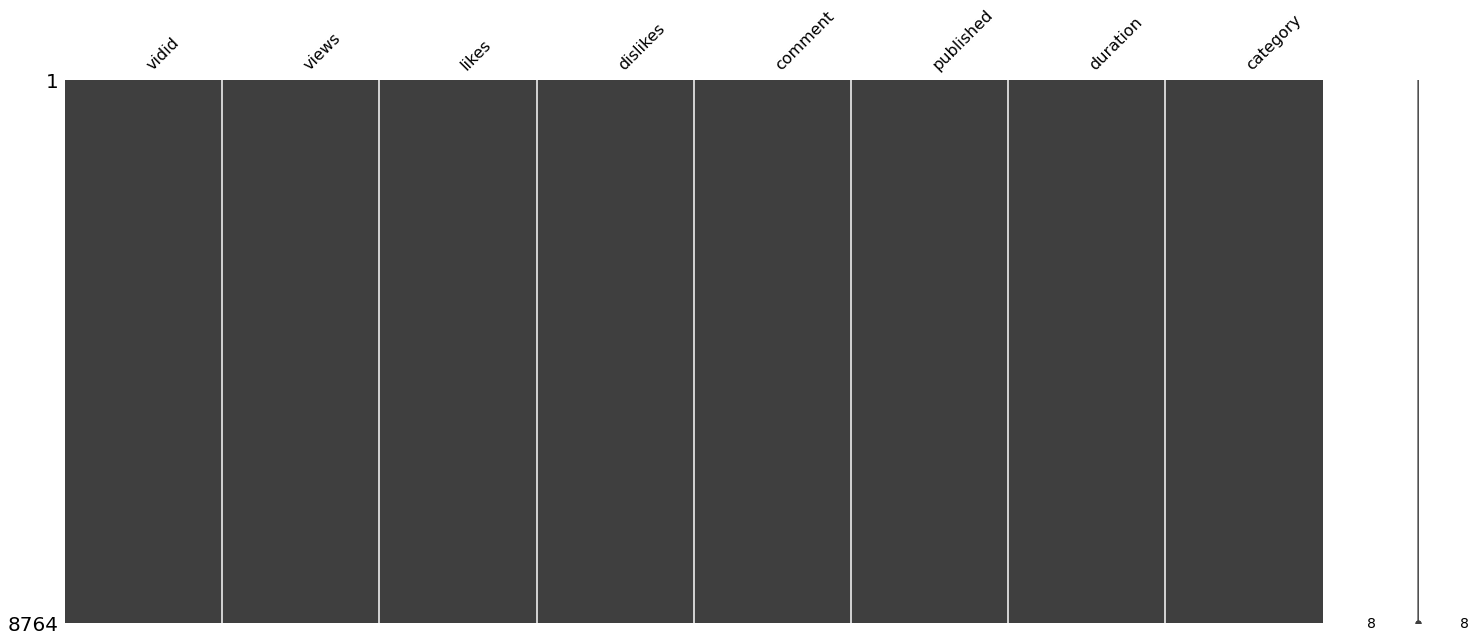

In [69]:
msno.matrix(test_df)

### 4.2.8. Report - Data Exploration
- The shape of train and test datasets are (14999, 9) & (8764, 8)
- There is no null value present in both dataset.
- Some categorical columns should convert to numerical.
- e.g 'views', 'likes', 'dislikes', 'comment'.


### 4.3. Train & Test Data Comparison

Here we'll compare below things between train and test dataset.
- Data Type
- Null values
- Data Distribution

### 4.3.1. Data Type Comparison

In [70]:
# as 'SalePrice' Column is not available in test dataset. So we'll delete it.
trn_dtype = train_dtype.drop('adview')
trn_dtype.compare(test_dtype)

,self,other


- The data type of each columns is same in both train and test dataframe

### 4.3.2. Null Value Comparison

In [71]:
null_train = train_df.isnull().sum()
null_test = test_df.isnull().sum()
null_train = null_train.drop('adview')
null_comp_df = null_train.compare(null_test).sort_values(['self'],ascending = [False])
null_comp_df  

,self,other


- Here we can see that there is no null value present in test and train dataset.

### 4.3.3. Distribution Comparison
Before going for distribution comparison,let's do some data preprocessing which will help in data analysis.

### 4.3.3.1 Convert Categorical column to numerical

In [72]:
convert_col = ['views', 'likes', 'dislikes', 'comment']
# these columns contain 'F' letter. So replace it by '0'. As we are converting columns to numerical.
for col in convert_col:
  train_df[col].replace({"F": 0}, inplace=True)
  test_df[col].replace({"F": 0}, inplace=True)


# Convert "categorical" feature to "numerical"
for col in convert_col:
  train_df[col] = train_df[col].astype('int')
  test_df[col] = test_df[col].astype('int')

### 4.3.3.2. Temporal variable analysis

In [73]:
train_df.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [74]:
# convert "duration" column format into "second" format
def checki(x):
    y = x[2:]
    h = ''
    m = ''
    s = ''
    mm = ''
    P = ['H','M','S']
    for i in y:
        if i not in P:
            mm+=i
        else:
            if(i=="H"):
                h = mm
                mm = ''
            elif(i == "M"):
                m = mm
                mm = ''
            else:
                s = mm
                mm = ''
    if(h==''):
        h = '00'
    if(m == ''):
        m = '00'
    if(s==''):
        s='00'
    bp = h+':'+m+':'+s
    return bp

train_mp = train_df["duration"]
test_mp = test_df["duration"]

train_time = train_mp.apply(checki)
test_time = test_mp.apply(checki)

def func_sec(time_string):
    h, m, s = time_string.split(":")
    return int(h) * 3600 + int(m) * 60 + int(s)

train_time=train_time.apply(func_sec)
test_time=test_time.apply(func_sec)

train_df["duration"]=train_time
test_df["duration"]=test_time
# train_df.head()

### 4.3.3.3. Convert 'date' to 'year' format in 'published' column

In [75]:
train_df['published'] = pd.DatetimeIndex(train_df['published']).year
test_df['published'] = pd.DatetimeIndex(test_df['published']).year

# convert to numerical feature
train_df['published'] = train_df['published'].astype('int')
test_df['published'] = test_df['published'].astype('int')

In [76]:
train_df.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016,457,F
1,VID_14135,2,1707,56,2,6,2016,570,D
2,VID_2187,1,2023,25,0,2,2016,136,C
3,VID_23096,6,620860,777,161,153,2016,262,H
4,VID_10175,1,666,1,0,0,2016,31,D


In [77]:
numerical_features = [col for col in train_df.columns if train_df[col].dtypes != 'O']
discrete_features = [col for col in numerical_features if len(train_df[col].unique()) < 10 and col not in ['vidid']]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features+['vidid']]
categorical_features = [col for col in train_df.columns if train_df[col].dtype == 'O']

print("Total Number of Numerical Columns : ",len(numerical_features))
print("Number of discrete features : ",len(discrete_features))
print("No of continuous features are : ", len(continuous_features))
print("Number of categorical features : ",len(categorical_features))

Total Number of Numerical Columns :  7
Number of discrete features :  0
No of continuous features are :  7
Number of categorical features :  2


### 4.3.3.4. Concat Train and Test datasets

In [78]:
# combined train and test datasets
combined_df = pd.concat([train_df,test_df],axis=0)

combined_df["Label"] = "test"
combined_df["Label"][:14999] = "train"

### 4.3.4. Distribution Comparison - Continuous

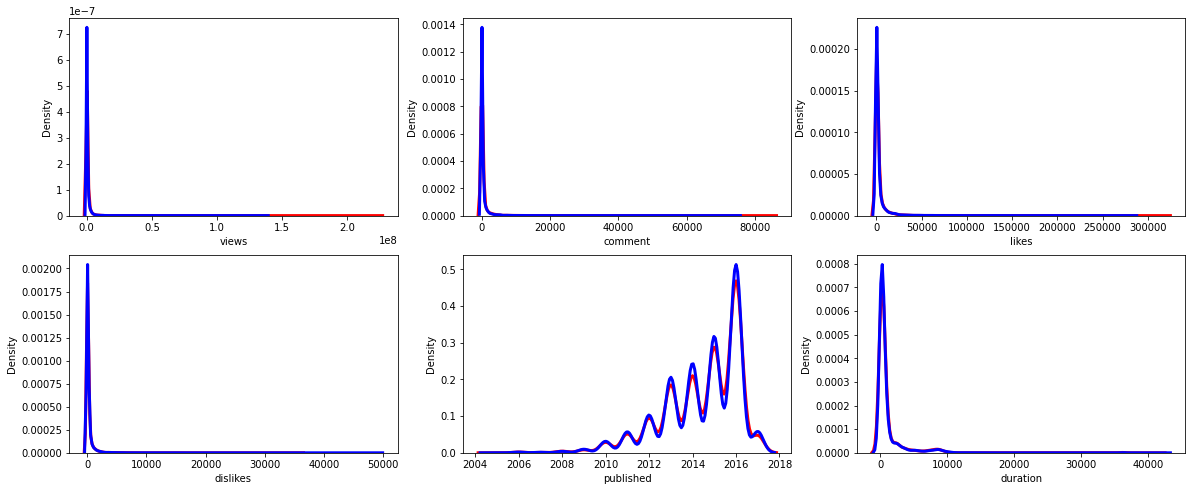

In [79]:
plt.figure(figsize=(20, 8))
continuous_features = ['views', 'comment', 'likes', 'dislikes','published', 'duration']
pos = 1
for i, feature in enumerate(continuous_features):
  plt.subplot(2 , 3 , pos)
  sns.distplot(test_df[feature], hist = False, kde = True, kde_kws = {'linewidth': 3},color='r' )
  sns.distplot(train_df[feature], hist = False, kde = True, kde_kws = {'linewidth': 3} ,color='b')
  pos = pos + 1


Above distribution shows that:
- The distribution of train and test data are similar for most continous features.
- All distributions are not **normally distributed**.

### 4.3.5. Linearity Check
Here we'll see the linearity between all features and the target variable.

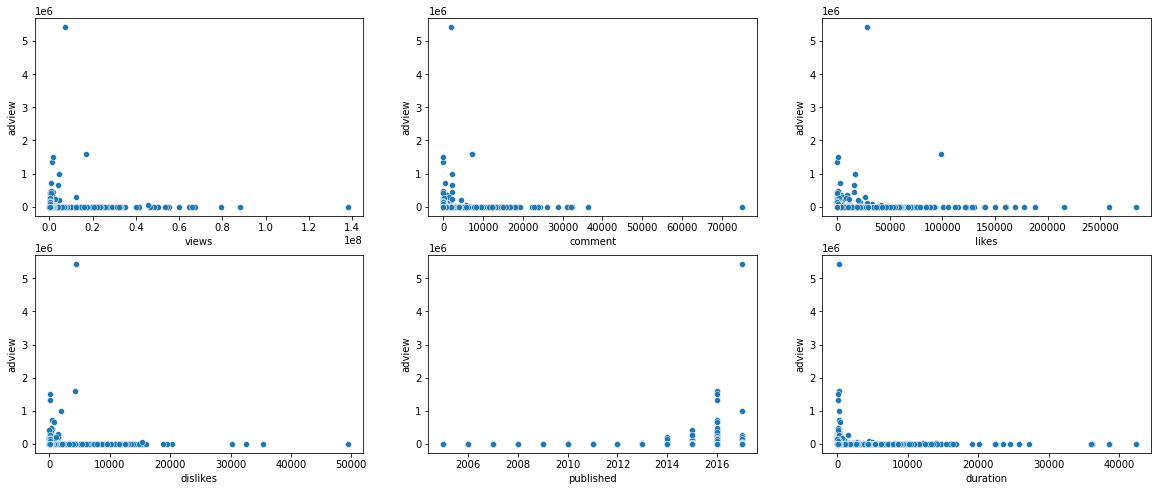

In [80]:
plt.figure(figsize=(20, 8))
pos = 1
for i, feature in enumerate(continuous_features):
  plt.subplot(2 , 3 , pos)
  sns.scatterplot(data=combined_df, x = feature, y= "adview")
  pos = pos + 1


### 4.3.6. Distribution Comparison - Categorical 
- There are two categorical features. These are **"category", "vidid"**.
- **"vidid"** is the id of video. So it has no impact to target variable.
- So we'll only check the distribution of **"category"** column.

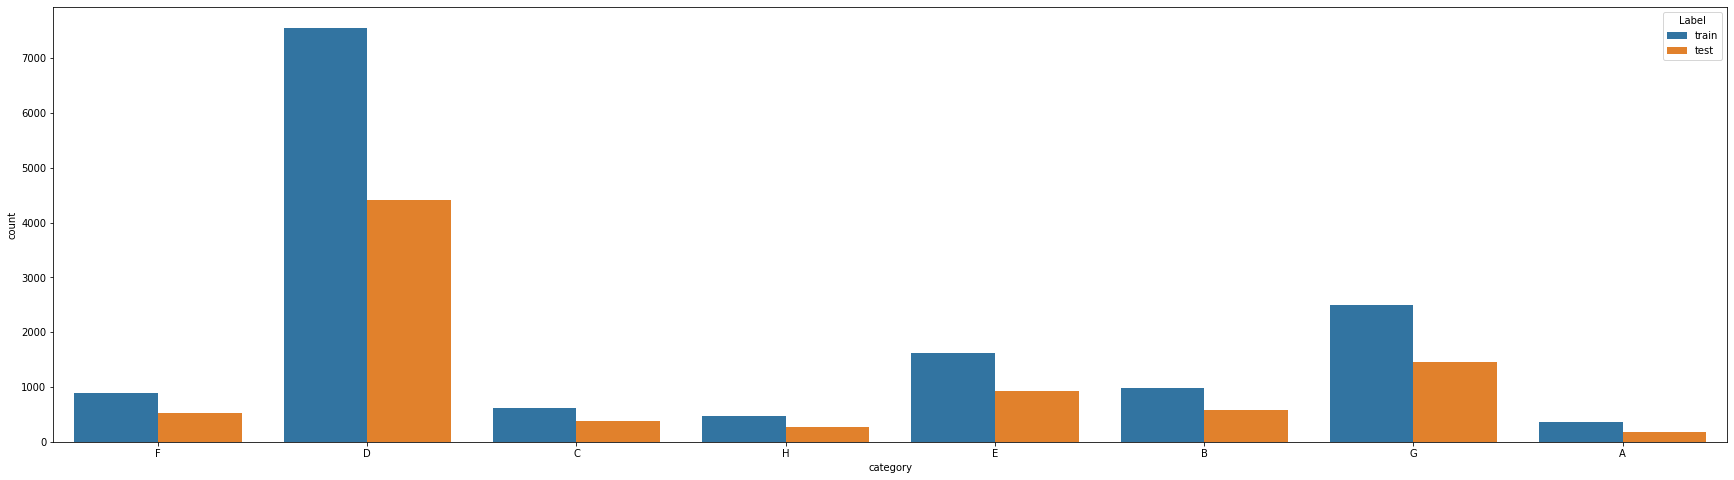

In [81]:
plt.figure(figsize=(30, 8))
sns.countplot(data = combined_df, x = 'category', hue="Label")

Above distribution shows that:

- The distribution of train and test data are similar for most categorical features.


### 4.3.7. Distribution - Target Variable

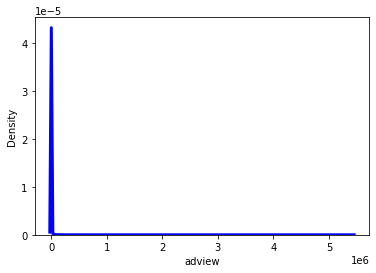

In [82]:
sns.distplot(train_df["adview"], hist = False, kde = True, kde_kws = {'linewidth': 3} ,color='b')

### 4.3.8. Data Correlation

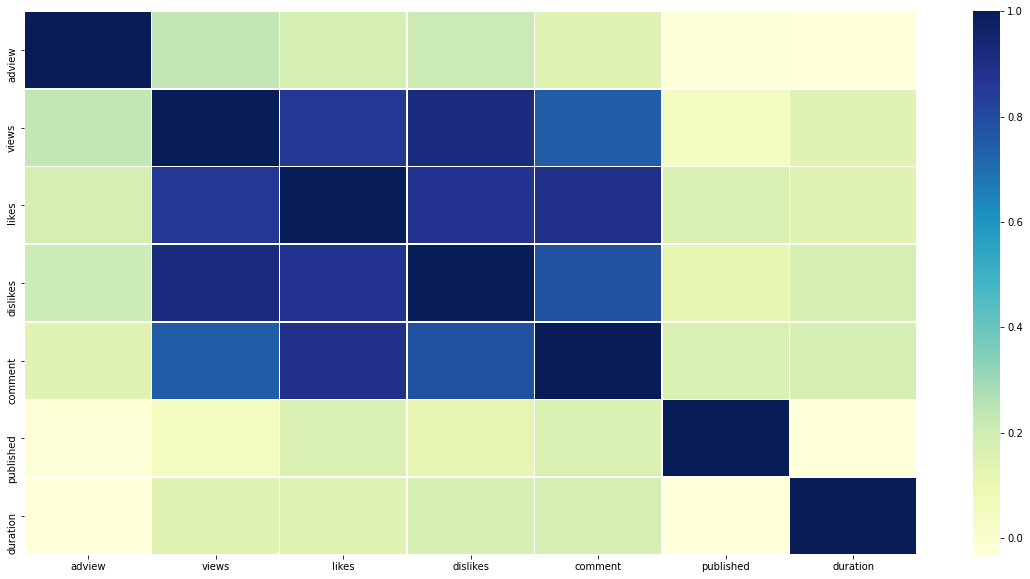

In [83]:
training_corr = train_df.corr(method='spearman') 
plt.figure(figsize=(20,10))
sns.heatmap(training_corr,cmap="YlGnBu", linewidths=.5) 

#**5. Feature Engineering**

### 5.1. Drop Columns
Here we'll drop unnecessary columns



In [84]:
drop_columns = ["vidid",'Label','published','duration']

#  Drop columns
print("Number of columns before dropping : ",len(combined_df.columns))
print("Number of dropping columns : ",len(drop_columns))
combined_df.drop(columns=drop_columns, inplace=True, errors='ignore')
print("Number of columns after dropping : ",len(combined_df.columns))


Number of columns before dropping :  10
Number of dropping columns :  4
Number of columns after dropping :  6


### 5.2. Apply PowerTransformer to columns
- We saw in distribution of continuous features that some features are not linear towards target feature. So we need to transform this. 
- Lets check the skewness of these distributions


In [85]:
# check the skew of all numerical features
skew_check_col = ['views','likes','dislikes','comment']
skewed_feats = combined_df[skew_check_col].apply(lambda x : skew(x.dropna())).sort_values(ascending = False)
print('\n Skew in numberical features: \n')
skewness_df = pd.DataFrame({'Skew' : skewed_feats})
print(skewness_df.head(7))


 Skew in numberical features: 

               Skew
views     29.926939
comment   18.761969
dislikes  18.269315
likes     11.914098


In [86]:

for col in skew_check_col:
  power = PowerTransformer(method='yeo-johnson', standardize=True)
  combined_df[[col]] = power.fit_transform(combined_df[[col]]) # fit with combined_data to avoid overfitting with training data

print('Number of skewed numerical features got transform : ', len(skew_check_col))

Number of skewed numerical features got transform :  4


### 5.7. Encoding Categorical Features

### Get-Dummies


In [87]:
# Generate one-hot dummy columns
combined_df = pd.get_dummies(combined_df).reset_index(drop=True)


In [88]:
combined_df.head()

,adview,views,likes,dislikes,comment,category_A,category_B,category_C,category_D,category_E,category_F,category_G,category_H
0,40.0,1.000244,1.441680,1.103359,1.398827,0,0,0,0,0,1,0,0
1,2.0,-1.693941,-0.819659,-1.200594,-0.781064,0,0,0,1,0,0,0,0
2,1.0,-1.641413,-1.119185,-1.747128,-1.168045,0,0,1,0,0,0,0,0
3,6.0,0.722749,0.280058,0.723964,0.577704,0,0,0,0,0,0,0,1
4,1.0,-1.970231,-2.009511,-1.747128,-1.679421,0,0,0,1,0,0,0,0


In [89]:
new_train_data = combined_df.iloc[:len(train_df), :]
new_test_data = combined_df.iloc[len(train_df):, :]
X_train = new_train_data.drop('adview', axis=1)
y_train = np.log1p(new_train_data['adview'].values.ravel())
X_test = new_test_data.drop('adview', axis=1)

In [90]:
# Make Pipeline
pre_precessing_pipeline = make_pipeline(RobustScaler())

X_train = pre_precessing_pipeline.fit_transform(X_train)
X_test = pre_precessing_pipeline.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(14999, 12)
(8764, 12)


# **6. Model Development**

### 6.2. Hyperparameter Tuning using Optuna

In [91]:
RANDOM_SEED = 23

# 10-fold CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

In [92]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

### 6.3. Ridge Regression

In [93]:
def ridge_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.1, 20)

    ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        ridge,X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# ridge_params = tune(ridge_objective)


# Best score: -1.898690687982798 
ridge_params = {'alpha': 19.99855836300504}

In [94]:
ridge = Ridge(**ridge_params, random_state=RANDOM_SEED)
ridge.fit(X_train,y_train)

Ridge(alpha=19.99855836300504, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=23, solver='auto', tol=0.001)

### 6.4. Lasso Regression

In [95]:
def lasso_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.0001, 1)

    lasso = Lasso(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        lasso,X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


# lasso_params = tune(lasso_objective)

# Best score: -1.8987548559962844 
lasso_params =  {'alpha': 0.0009661425571276957}

In [96]:
lasso = Lasso(**lasso_params, random_state=RANDOM_SEED)
lasso.fit(X_train,y_train)

Lasso(alpha=0.0009661425571276957, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=23, selection='cyclic', tol=0.0001, warm_start=False)

### 6.5. Gradient Boosting Regressor

In [97]:
def gbr_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 20)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 20)
    _max_features = trial.suggest_int("max_features", 10, 50)

    gbr = GradientBoostingRegressor(
        n_estimators=_n_estimators,
        learning_rate=_learning_rate,
        max_depth=_max_depth, 
        max_features=_max_features,
        min_samples_leaf=_min_samples_leaf,
        min_samples_split=_min_samp_split,
        
        random_state=RANDOM_SEED,
    )

    score = cross_val_score(
        gbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score

# gbr_params = tune(gbr_objective)

# Best score: -1.8222372332051289 
gbr_params = {'n_estimators': 1396, 'learning_rate': 0.014373145732630006, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 10}

In [98]:
gbr = GradientBoostingRegressor(random_state=RANDOM_SEED, **gbr_params)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.014373145732630006,
                          loss='ls', max_depth=6, max_features=10,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=7,
                          min_samples_split=6, min_weight_fraction_leaf=0.0,
                          n_estimators=1396, n_iter_no_change=None,
                          presort='deprecated', random_state=23, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

### 6.6. XGBRegressor 

In [99]:
def xgb_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _gamma = trial.suggest_float("gamma", 0.01, 1)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)

    
    xgbr = xgb.XGBRegressor(
        n_estimators=_n_estimators,
        max_depth=_max_depth, 
        learning_rate=_learning_rate,
        gamma=_gamma,
        min_child_weight=_min_child_weight,
        subsample=_subsample,
        reg_alpha=_reg_alpha,
        reg_lambda=_reg_lambda,
        random_state=RANDOM_SEED,
    )
    

    score = cross_val_score(
        xgbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


# xgb_params = tune(xgb_objective)

xgb_params =  {'n_estimators': 75, 'max_depth': 4, 'learning_rate': 0.27059503805300894, 'gamma': 0.6375378736305962, 'min_child_weight': 3.2347222003450633, 'subsample': 0.8792064649951686, 'reg_alpha': 8.764034303437914, 'reg_lambda': 7.475836220328881}
# Best score : -1.8258592810003325.

In [100]:
xgbr = xgb.XGBRegressor(random_state=RANDOM_SEED, **xgb_params)
xgbr.fit(X_train,y_train)

[16:30:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.6375378736305962,
             importance_type='gain', learning_rate=0.27059503805300894,
             max_delta_step=0, max_depth=4, min_child_weight=3.2347222003450633,
             missing=None, n_estimators=75, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=23,
             reg_alpha=8.764034303437914, reg_lambda=7.475836220328881,
             scale_pos_weight=1, seed=None, silent=None,
             subsample=0.8792064649951686, verbosity=1)

### 6.7. LGBMRegressor

In [101]:
import lightgbm as lgb

def lgb_objective(trial):
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 1, 20)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _n_estimators = trial.suggest_int("n_estimators", 50, 2000)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    _reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10)
    _reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10)
    _subsample = trial.suggest_float('subsample', 0.01, 1)


    
    lgbr = lgb.LGBMRegressor(objective='regression',
                             num_leaves=_num_leaves,
                             max_depth=_max_depth,
                             learning_rate=_learning_rate,
                             n_estimators=_n_estimators,
                             min_child_weight=_min_child_weight,
                             subsample=_subsample,
                             reg_alpha=_reg_alpha,
                             reg_lambda=_reg_lambda,
                             random_state=RANDOM_SEED,
    )
    

    score = cross_val_score(
        lgbr, X_train,y_train, cv=kfolds, scoring="neg_root_mean_squared_error"
    ).mean()
    return score


# lgb_params = tune(lgb_objective)

# Best score: -1.824529794158143 
lgb_params =  {'num_leaves': 84, 'max_depth': 10, 'learning_rate': 0.011076909667786489, 'n_estimators': 727, 'min_child_weight': 4.921109754366219, 'reg_alpha': 4.370797996109474, 'reg_lambda': 8.552921079737136, 'subsample': 0.4411906869457217}


In [102]:
lgbr = lgb.LGBMRegressor(objective='regression', random_state=RANDOM_SEED, **lgb_params)
lgbr.fit(X_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.011076909667786489,
              max_depth=10, min_child_samples=20,
              min_child_weight=4.921109754366219, min_split_gain=0.0,
              n_estimators=727, n_jobs=-1, num_leaves=84,
              objective='regression', random_state=23,
              reg_alpha=4.370797996109474, reg_lambda=8.552921079737136,
              silent=True, subsample=0.4411906869457217,
              subsample_for_bin=200000, subsample_freq=0)

### 6.8. StackingRegressor

In [103]:
# stack models
stack = StackingRegressor(
    estimators=[
        ('ridge', ridge),
        ('lasso', lasso),
        ('gradientboostingregressor', gbr),
        ('xgb', xgbr),
        ('lgb', lgbr),
        # ('svr', svr), # Not using this for now as its score is significantly worse than the others
    ],
    cv=kfolds)
stack.fit(X_train,y_train)

[16:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

StackingRegressor(cv=KFold(n_splits=10, random_state=23, shuffle=True),
                  estimators=[('ridge',
                               Ridge(alpha=19.99855836300504, copy_X=True,
                                     fit_intercept=True, max_iter=None,
                                     normalize=False, random_state=23,
                                     solver='auto', tol=0.001)),
                              ('lasso',
                               Lasso(alpha=0.0009661425571276957, copy_X=True,
                                     fit_intercept=True, max_iter=1000,
                                     normalize=False, positive=False,
                                     precompu...
                                             max_depth=10, min_child_samples=20,
                                             min_child_weight=4.921109754366219,
                                             min_split_gain=0.0,
                                             n_estimators=727, n_job

### 6.9. Save the Model

In [104]:
joblib.dump(stack, "prediction_model.pkl")
model=joblib.load("prediction_model.pkl")
model

[16:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingRegressor(cv=KFold(n_splits=10, random_state=23, shuffle=True),
                  estimators=[('ridge',
                               Ridge(alpha=19.99855836300504, copy_X=True,
                                     fit_intercept=True, max_iter=None,
                                     normalize=False, random_state=23,
                                     solver='auto', tol=0.001)),
                              ('lasso',
                               Lasso(alpha=0.0009661425571276957, copy_X=True,
                                     fit_intercept=True, max_iter=1000,
                                     normalize=False, positive=False,
                                     precompu...
                                             max_depth=10, min_child_samples=20,
                                             min_child_weight=4.921109754366219,
                                             min_split_gain=0.0,
                                             n_estimators=727, n_job

# **7. Find Prediction**

In [105]:
print('Predict submission')
final_test_df = pd.read_csv("/content/test.csv")

final_test_df['AdView'] = np.round(np.expm1(model.predict(X_test))).astype(int)

final_test_df.to_csv('submission_test.csv', index=False)

Predict submission


In [106]:
final_test_df.head()

,vidid,views,likes,dislikes,comment,published,duration,category,AdView
0,VID_1054,440238,6153,218,1377,2017-02-18,PT7M29S,B,6
1,VID_18629,1040132,8171,340,1047,2016-06-28,PT6M29S,F,4
2,VID_13967,28534,31,11,1,2014-03-10,PT37M54S,D,3
3,VID_19442,1316715,2284,250,274,2010-06-05,PT9M55S,G,6
4,VID_770,1893173,2519,225,116,2016-09-03,PT3M8S,B,6
